In [1]:
# Import required libraries
import math
import time
import pandas as pd
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display, HTML

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Declare hyperparameters and model parameters
NUM_FEATURES = 21
NUM_CLASSES = 3

learning_rate = 0.01
epochs = 5000
batch_size = 32
num_neurons = 10
seed = 10
l2_beta = 10 ** -6

# Set initial seed so values are consistent
np.random.seed(seed)

DEBUG = False

In [3]:
# Function to scale features
def scale(X, X_min, X_max):
    return (X - X_min) / (X_max - X_min)

In [4]:
# Read train data
train_input = np.genfromtxt('ctg_data_cleaned.csv', delimiter= ',')

# Generate feature-scaled training data as input to model
X, Y_ = train_input[1:, :21], train_input[1:,-1].astype(int)

# Generate one-hot output as desired output of model
# Y_ is a list of classes, Y is the one-hot encoded version of Y_
Y = np.zeros((Y_.shape[0], NUM_CLASSES))
Y[np.arange(Y_.shape[0]), Y_ - 1] = 1 # One-hot matrix

In [5]:
# Visualize X
X_dataframe = pd.DataFrame(X, columns=pd.read_csv('ctg_data_cleaned.csv').columns[:21])
display(HTML(X_dataframe.to_html()))

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,MLTV,Width,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency
0,120.0,0.000,0.000,0.000,0.000,0.000,0.000,73.0,0.5,43.0,2.4,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0
1,132.0,0.006,0.000,0.006,0.003,0.000,0.000,17.0,2.1,0.0,10.4,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0
2,133.0,0.003,0.000,0.008,0.003,0.000,0.000,16.0,2.1,0.0,13.4,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0
3,134.0,0.003,0.000,0.008,0.003,0.000,0.000,16.0,2.4,0.0,23.0,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0
4,132.0,0.007,0.000,0.008,0.000,0.000,0.000,16.0,2.4,0.0,19.9,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0
5,134.0,0.001,0.000,0.010,0.009,0.000,0.002,26.0,5.9,0.0,0.0,150.0,50.0,200.0,5.0,3.0,76.0,107.0,107.0,170.0,0.0
6,134.0,0.001,0.000,0.013,0.008,0.000,0.003,29.0,6.3,0.0,0.0,150.0,50.0,200.0,6.0,3.0,71.0,107.0,106.0,215.0,0.0
7,122.0,0.000,0.000,0.000,0.000,0.000,0.000,83.0,0.5,6.0,15.6,68.0,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0
8,122.0,0.000,0.000,0.002,0.000,0.000,0.000,84.0,0.5,5.0,13.6,68.0,62.0,130.0,0.0,0.0,122.0,122.0,123.0,3.0,1.0
9,122.0,0.000,0.000,0.003,0.000,0.000,0.000,86.0,0.3,6.0,10.6,68.0,62.0,130.0,1.0,0.0,122.0,122.0,123.0,1.0,1.0


In [6]:
# Create the model with 3 layers (1 hidden layer)
def model_3_layers(num_neurons, decay_parameter, debug=False):
    x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    # Build the graph for the deep net
    W1 = tf.Variable(tf.truncated_normal([NUM_FEATURES, num_neurons], stddev=1.0/math.sqrt(float(NUM_FEATURES)), seed=seed), name='W1')
    b1 = tf.Variable(tf.zeros([num_neurons]), name='b1')
    H1 = tf.nn.relu(tf.matmul(x, W1) + b1)

    W2 = tf.Variable(tf.truncated_normal([num_neurons, NUM_CLASSES], stddev=1.0/math.sqrt(float(num_neurons)), seed=seed), name='W2')
    b2 = tf.Variable(tf.zeros([NUM_CLASSES]), name='b2')
    logits = tf.matmul(H1, W2) + b2
    Y = tf.nn.softmax(logits)

    # Compute regularization term
    regularization_term = decay_parameter * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2))
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
    loss = tf.reduce_mean(cross_entropy) + regularization_term
    
    # Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)

    correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1)), tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)
    
    if debug:
        return train_op, loss, accuracy, {"x": x, "y_": y_, "W1": W1, "b1": b1, "H1": H1, "W2": W2, "b2": b2, 
                                          "logits": logits, "Y": Y, "regularization_term": regularization_term}
    else:
        return train_op, loss, accuracy, {"x": x, "y_": y_}

In [7]:
# Question 5
# Neural Network with 4 layers

# Create the model with 4 layers (2 hidden layers)
def model_4_layers(num_neurons, decay_parameter, debug=False):
    # Create the model
    x = tf.placeholder(tf.float32, [None, NUM_FEATURES])
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

    # Build the graph for the deep net
    W1 = tf.Variable(tf.truncated_normal([NUM_FEATURES, num_neurons], stddev=1.0/math.sqrt(float(NUM_FEATURES)), seed=seed), name='W1')
    b1 = tf.Variable(tf.zeros([num_neurons]), name='b1')
    H1 = tf.nn.relu(tf.matmul(x, W1) + b1)

    W2 = tf.Variable(tf.truncated_normal([num_neurons, num_neurons], stddev=1.0/math.sqrt(float(num_neurons)), seed=seed), name='W2')
    b2 = tf.Variable(tf.zeros([num_neurons]), name='b2')
    H2 = tf.nn.relu(tf.matmul(H1, W2) + b2)
    
    W3 = tf.Variable(tf.truncated_normal([num_neurons, NUM_CLASSES], stddev=1.0/math.sqrt(float(num_neurons)), seed=seed), name='W3')
    b3 = tf.Variable(tf.zeros([NUM_CLASSES]), name='b3')
    logits = tf.matmul(H2, W3) + b3
    Y = tf.nn.softmax(logits)

    # Compute regularization term
    regularization_term = decay_parameter * (tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3))
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
    loss = tf.reduce_mean(cross_entropy) + regularization_term
    
    # Create the gradient descent optimizer with the given learning rate.
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    train_op = optimizer.minimize(loss)

    correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1)), tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)
    
    if debug:
        return train_op, loss, accuracy, {"x": x, "y_": y_, "W1": W1, "b1": b1, "H1": H1, "W2": W2, "b2": b2, "H2": H2,
                                          "W3": W3, "b3": b3, "logits": logits, "Y": Y,
                                          "regularization_term": regularization_term}
    else:
        return train_op, loss, accuracy, {"x": x, "y_": y_}

In [8]:
# Training function, model choices and hyperparameter choices, including batch size for minibatch gradient descent
# are chosen here.
def training(trainX, trainY, num_classes, decay_parameter, batch_size, no_of_layers, testX=None, testY=None,
             use_small_dataset=True):
    with tf.Session() as sess:
        train_acc = []
        test_acc = []
        losses = []
        
        if use_small_dataset:
            # Get model with debug values
            if no_of_layers == 3:
                model, loss, accuracy, debug_values = model_3_layers(num_classes, decay_parameter, debug=True)
                x, y_, W1, b1, H1, W2, b2, logits, Y, regularization_term = debug_values["x"], debug_values["y_"], debug_values["W1"], debug_values["b1"], debug_values["H1"], debug_values["W2"], debug_values["b2"], debug_values["logits"], debug_values["Y"], debug_values["regularization_term"]
            elif no_of_layers == 4:
                model, loss, accuracy, debug_values = model_4_layers(num_classes, decay_parameter, debug=True)
                x, y_, W1, b1, H1, W2, b2, H2, W3, b3, logits, Y, regularization_term = debug_values["x"], debug_values["y_"], debug_values["W1"], debug_values["b1"], debug_values["H1"], debug_values["W2"], debug_values["b2"], debug_values["H2"], debug_values["W3"], debug_values["b3"], debug_values["logits"], debug_values["Y"], debug_values["regularization_term"]
        else:
            # Get model with feed_dict values
            if no_of_layers == 3:
                model, loss, accuracy, feed_dict_values = model_3_layers(num_classes, decay_parameter)
                x, y_ = feed_dict_values["x"], feed_dict_values["y_"]
            elif no_of_layers == 4:
                model, loss, accuracy, feed_dict_values = model_4_layers(num_classes, decay_parameter)
                x, y_ = feed_dict_values["x"], feed_dict_values["y_"]
                
            # Reseed so shuffled data for mini-batch gradient descent are consistent with each training
            np.random.seed(seed)
            
        # Initialize weights and biases in the model chosen
        sess.run(tf.global_variables_initializer())
        
        for i in range(epochs):
            if use_small_dataset:
                # Debugging
                model.run(feed_dict={x_: trainX, y_: trainY})
                train_acc.append(accuracy.eval(feed_dict={x: trainX, y_: trainY}))

                if i == 0 or i == epochs - 1:
                    x_, y__, logits_, W1_, b1_, H1_, W2_, b2_, regularization_term_, Y_ = sess.run([x, y_, logits, W1, b1, H1, W2, b2, regularization_term, Y], feed_dict={x: trainX, y_: trainY})
                    print('iteration %d:' % (i))
                    print('X: ', x_)
                    print('Y: ', y__)
                    print('W1: ', W1_)
                    print('b1:', b1_)
                    print('H1: ', H1_)
                    print('W2: ', W2_)
                    print('b2: ', b2_)
                    print('Logits: ', logits_)
                    print('Y: ', Y_)
                    print('Regularization term: ', regularization_term_)

                if i % 100 == 0:
                    print('iter %d: accuracy %g'%(i, train_acc[i]))
            else:
                # Shuffle the dataset before grouping them into minibatches for gradient updates
                dataset_size = trainX.shape[0]
                idx = np.arange(dataset_size)
                np.random.shuffle(idx)
                trainX, trainY = trainX[idx], trainY[idx]
                
                # Initialize initial average epoch training accuracy
                avg_epoch_train_acc = 0
                no_of_minibatches = math.ceil(dataset_size / batch_size)

                # Mini-batch gradient descent
                for start, end in zip(range(0, dataset_size, batch_size), range(batch_size, dataset_size, batch_size)):
                    model.run(feed_dict={x: trainX[start:end], y_: trainY[start:end]})
                    avg_epoch_train_acc += accuracy.eval(feed_dict={x: trainX[start:end], y_: trainY[start:end]}) / no_of_minibatches
                    
                # Append training and test accuracies per epoch
                train_acc.append(avg_epoch_train_acc)
                test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY}))
                losses.append(loss.eval(feed_dict={x: trainX, y_: trainY}))
                    
                if i % 100 == 0:
                    print('iter %d: accuracy %g, test accuracy %g, loss %g'%(i, train_acc[i], test_acc[i], losses[i]))

        return train_acc, test_acc, losses

In [9]:
# Decide to use small dataset or whole dataset with cross-validation techniques

if DEBUG:
    # Get first 1000 tuples.
    trainX = X[:1000]
    trainY = Y[:1000]
    n = trainX.shape[0]
    train_acc, test_acc, losses = training(trainX, trainY, num_classes=10, decay_parameter=10 ** -6,
                                           batch_size=32, no_of_layers=3)
else:
    # QUESTION 1
    # Shuffle the dataset.
    dataset_size = X.shape[0]
    benchmark_idx = np.arange(dataset_size)
    np.random.shuffle(benchmark_idx)
    X_shuffled, Y_shuffled = X[benchmark_idx], Y[benchmark_idx]
    
    # Split the dataset to 70:30; 70 for training and 30 for testing
    idx_split = math.ceil(X_shuffled.shape[0] / 5 * 0.7) * 5
    
    # cv_and_trainX and cv_and_trainY will continually be used in later questions for hyperparameter tuning
    cv_and_trainX = scale(X_shuffled[:idx_split], np.min(X_shuffled[:idx_split], axis=0), np.max(X_shuffled[:idx_split], axis=0)) 
    testX = scale(X_shuffled[idx_split:], np.min(X_shuffled[:idx_split], axis=0), np.max(X_shuffled[:idx_split], axis=0))
    cv_and_trainY, testY = Y_shuffled[:idx_split], Y_shuffled[idx_split:]

    train_acc, test_acc, losses = training(cv_and_trainX, cv_and_trainY, num_classes=10, decay_parameter=10 ** -6, batch_size=32,
                                  no_of_layers=3, testX=testX, testY=testY, use_small_dataset=False)

iter 0: accuracy 0.756649, test accuracy 0.784591, loss 0.826374
iter 100: accuracy 0.84109, test accuracy 0.867925, loss 0.350229
iter 200: accuracy 0.862367, test accuracy 0.897799, loss 0.27633
iter 300: accuracy 0.87766, test accuracy 0.899371, loss 0.253321
iter 400: accuracy 0.881649, test accuracy 0.900943, loss 0.242554
iter 500: accuracy 0.880984, test accuracy 0.899371, loss 0.23579
iter 600: accuracy 0.880984, test accuracy 0.902516, loss 0.229402
iter 700: accuracy 0.880319, test accuracy 0.90566, loss 0.224875
iter 800: accuracy 0.885638, test accuracy 0.908805, loss 0.221204
iter 900: accuracy 0.888963, test accuracy 0.91195, loss 0.217517
iter 1000: accuracy 0.884973, test accuracy 0.902516, loss 0.215104
iter 1100: accuracy 0.890957, test accuracy 0.91195, loss 0.212134
iter 1200: accuracy 0.888963, test accuracy 0.90566, loss 0.208868
iter 1300: accuracy 0.889628, test accuracy 0.908805, loss 0.206251
iter 1400: accuracy 0.891622, test accuracy 0.913522, loss 0.206374


Final training accuracy is 0.9155585106382982
Final test accuracy is 0.9088050127029419


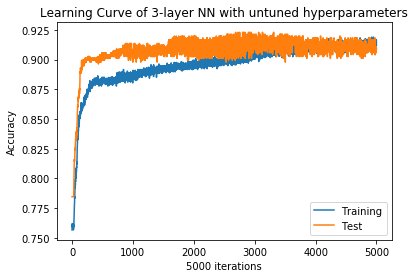

In [10]:
# Plot learning curves
print('Final training accuracy is {}'.format(train_acc[-1]))
print('Final test accuracy is {}'.format(test_acc[-1]))

fig, ax = plt.subplots()
ax.plot(range(epochs), train_acc, label='Training')
ax.plot(range(epochs), test_acc, label='Test')
legend = ax.legend(loc='lower right')

plt.xlabel(str(epochs) +' iterations')
plt.ylabel('Accuracy')
plt.title('Learning Curve of 3-layer NN with untuned hyperparameters')
plt.savefig('figures/project_1a_q1a.png')
plt.show()

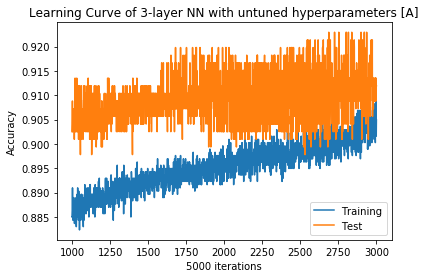

In [11]:
fig, ax = plt.subplots()
ax.plot(range(epochs)[1000:3001], train_acc[1000:3001], label='Training')
ax.plot(range(epochs)[1000:3001], test_acc[1000:3001], label='Test')
legend = ax.legend(loc='lower right')

plt.xlabel(str(epochs) +' iterations')
plt.ylabel('Accuracy')
plt.title('Learning Curve of 3-layer NN with untuned hyperparameters [A]')
plt.savefig('figures/project_1a_q1b_1.png')
plt.show()

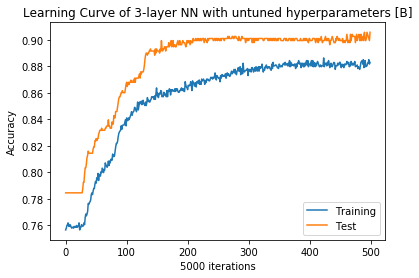

In [13]:
fig, ax = plt.subplots()
ax.plot(range(epochs)[0:500], train_acc[0:500], label='Training')
ax.plot(range(epochs)[0:500], test_acc[0:500], label='Test')
legend = ax.legend(loc='lower right')

plt.xlabel(str(epochs) +' iterations')
plt.ylabel('Accuracy')
plt.title('Learning Curve of 3-layer NN with untuned hyperparameters [B]')
plt.savefig('figures/project_1a_q1b_2.png')
plt.show()

Final loss is 0.1623595654964447


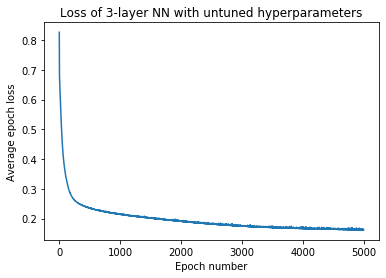

In [14]:
# Plot learning curves
print('Final loss is {}'.format(losses[-1]))
plt.plot(range(epochs), losses)
plt.xlabel('Epoch number')
plt.ylabel('Average epoch loss')
plt.title('Loss of 3-layer NN with untuned hyperparameters')
plt.savefig('figures/project_1a_q1b_3.png')
plt.show()

In [15]:
# QUESTION 2
# Optimal batch size
BATCH_SIZES = [4, 8, 16, 32, 64]

batch_size_train_accs = []
batch_size_test_accs = []
batch_losses = []
batch_times = []

# Try training with different batch sizes
for batch_size in BATCH_SIZES:
    print("==============")
    print("USING BATCH SIZE = {}".format(batch_size))
    print("==============")
    
    train_accs = []
    cross_validation_accs = []
    losses = []
    total_time_taken = 0
    
    # Further split trainX and trainY to do 5-fold cross-validation
    for fold in range(5):
        print("==============")
        print("FOLD {}".format(fold + 1))
        print("==============")

        # Find indexes to split dataset further.
        start_idx = fold * int(idx_split / 5)
        end_idx = (fold + 1) * int(idx_split / 5)

        # Split training dataset further to training and test set.
        trainX = np.append(cv_and_trainX[:start_idx], cv_and_trainX[end_idx:], axis=0)
        trainY = np.append(cv_and_trainY[:start_idx], cv_and_trainY[end_idx:], axis=0)
        cv_X = cv_and_trainX[start_idx:end_idx]
        cv_Y = cv_and_trainY[start_idx:end_idx]

        # Train the model.
        start_time = time.time()
        train_acc, cv_acc, loss = training(trainX, trainY, num_classes=10, decay_parameter=10 ** -6, batch_size=batch_size,
                                           no_of_layers=3, testX=cv_X, testY=cv_Y, use_small_dataset=False)
        time_taken = time.time() - start_time
        
        # Record cross-validation accuracies of model and total time taken per epoch
        train_accs.append(train_acc)
        cross_validation_accs.append(cv_acc)
        losses.append(loss)
        total_time_taken += time_taken / epochs

    # Find mean model training and cross-validation accuracies per epoch and average time taken for different batch sizes.
    model_train_accs_avg = np.average(np.array(train_accs), axis=0).tolist()
    model_test_accs_avg = np.average(np.array(cross_validation_accs), axis=0).tolist()
    losses_avg = np.average(np.array(losses), axis=0).tolist()
    
    batch_size_train_accs.append(model_train_accs_avg)
    batch_size_test_accs.append(model_test_accs_avg)
    batch_losses.append(losses_avg)
    batch_times.append(total_time_taken / 5)

USING BATCH SIZE = 4
FOLD 1
iter 0: accuracy 0.768456, test accuracy 0.791946, loss 0.670053
iter 100: accuracy 0.906879, test accuracy 0.895973, loss 0.228593
iter 200: accuracy 0.91443, test accuracy 0.90604, loss 0.214831
iter 300: accuracy 0.916946, test accuracy 0.892617, loss 0.200769
iter 400: accuracy 0.924497, test accuracy 0.892617, loss 0.203515
iter 500: accuracy 0.931208, test accuracy 0.892617, loss 0.179668
iter 600: accuracy 0.939597, test accuracy 0.892617, loss 0.171747
iter 700: accuracy 0.939597, test accuracy 0.892617, loss 0.1705
iter 800: accuracy 0.947148, test accuracy 0.899329, loss 0.175966
iter 900: accuracy 0.947148, test accuracy 0.895973, loss 0.164908
iter 1000: accuracy 0.948826, test accuracy 0.899329, loss 0.154481
iter 1100: accuracy 0.947987, test accuracy 0.899329, loss 0.162937
iter 1200: accuracy 0.950503, test accuracy 0.899329, loss 0.156564
iter 1300: accuracy 0.950503, test accuracy 0.899329, loss 0.148328
iter 1400: accuracy 0.948826, test a

iter 2000: accuracy 0.958054, test accuracy 0.899329, loss 0.133761
iter 2100: accuracy 0.958893, test accuracy 0.90604, loss 0.132888
iter 2200: accuracy 0.958893, test accuracy 0.872483, loss 0.140006
iter 2300: accuracy 0.956376, test accuracy 0.892617, loss 0.133002
iter 2400: accuracy 0.96057, test accuracy 0.916107, loss 0.136223
iter 2500: accuracy 0.958054, test accuracy 0.919463, loss 0.144571
iter 2600: accuracy 0.96057, test accuracy 0.902685, loss 0.127859
iter 2700: accuracy 0.955537, test accuracy 0.90604, loss 0.124752
iter 2800: accuracy 0.958893, test accuracy 0.902685, loss 0.124979
iter 2900: accuracy 0.96057, test accuracy 0.872483, loss 0.152695
iter 3000: accuracy 0.963926, test accuracy 0.912752, loss 0.129889
iter 3100: accuracy 0.961409, test accuracy 0.919463, loss 0.129264
iter 3200: accuracy 0.963926, test accuracy 0.902685, loss 0.131252
iter 3300: accuracy 0.959732, test accuracy 0.926175, loss 0.132942
iter 3400: accuracy 0.963926, test accuracy 0.922819,

iter 4000: accuracy 0.98406, test accuracy 0.926175, loss 0.0921697
iter 4100: accuracy 0.985738, test accuracy 0.926175, loss 0.0821247
iter 4200: accuracy 0.98406, test accuracy 0.932886, loss 0.0834057
iter 4300: accuracy 0.981544, test accuracy 0.939597, loss 0.0751135
iter 4400: accuracy 0.982383, test accuracy 0.922819, loss 0.083081
iter 4500: accuracy 0.985738, test accuracy 0.936242, loss 0.0725635
iter 4600: accuracy 0.982383, test accuracy 0.932886, loss 0.0828054
iter 4700: accuracy 0.983221, test accuracy 0.936242, loss 0.0713736
iter 4800: accuracy 0.988255, test accuracy 0.926175, loss 0.0748795
iter 4900: accuracy 0.985738, test accuracy 0.899329, loss 0.144123
USING BATCH SIZE = 8
FOLD 1
iter 0: accuracy 0.766779, test accuracy 0.791946, loss 0.699682
iter 100: accuracy 0.891779, test accuracy 0.899329, loss 0.252279
iter 200: accuracy 0.895973, test accuracy 0.895973, loss 0.230098
iter 300: accuracy 0.907718, test accuracy 0.892617, loss 0.216564
iter 400: accuracy 0

iter 1000: accuracy 0.921141, test accuracy 0.922819, loss 0.177503
iter 1100: accuracy 0.925336, test accuracy 0.919463, loss 0.177944
iter 1200: accuracy 0.927013, test accuracy 0.922819, loss 0.171714
iter 1300: accuracy 0.921141, test accuracy 0.90604, loss 0.170249
iter 1400: accuracy 0.92953, test accuracy 0.902685, loss 0.172357
iter 1500: accuracy 0.928691, test accuracy 0.919463, loss 0.178466
iter 1600: accuracy 0.924497, test accuracy 0.90604, loss 0.166844
iter 1700: accuracy 0.932047, test accuracy 0.899329, loss 0.174635
iter 1800: accuracy 0.926174, test accuracy 0.922819, loss 0.163523
iter 1900: accuracy 0.925336, test accuracy 0.919463, loss 0.164929
iter 2000: accuracy 0.931208, test accuracy 0.922819, loss 0.161857
iter 2100: accuracy 0.92953, test accuracy 0.899329, loss 0.163762
iter 2200: accuracy 0.927013, test accuracy 0.902685, loss 0.16693
iter 2300: accuracy 0.920302, test accuracy 0.912752, loss 0.160372
iter 2400: accuracy 0.932886, test accuracy 0.922819,

iter 3100: accuracy 0.949664, test accuracy 0.909396, loss 0.129841
iter 3200: accuracy 0.948826, test accuracy 0.916107, loss 0.133423
iter 3300: accuracy 0.950503, test accuracy 0.90604, loss 0.129801
iter 3400: accuracy 0.951342, test accuracy 0.909396, loss 0.127156
iter 3500: accuracy 0.947987, test accuracy 0.916107, loss 0.130792
iter 3600: accuracy 0.949664, test accuracy 0.90604, loss 0.125893
iter 3700: accuracy 0.950503, test accuracy 0.916107, loss 0.129558
iter 3800: accuracy 0.95302, test accuracy 0.902685, loss 0.131797
iter 3900: accuracy 0.95302, test accuracy 0.909396, loss 0.125056
iter 4000: accuracy 0.948826, test accuracy 0.90604, loss 0.124469
iter 4100: accuracy 0.948826, test accuracy 0.919463, loss 0.12319
iter 4200: accuracy 0.951342, test accuracy 0.90604, loss 0.121481
iter 4300: accuracy 0.951342, test accuracy 0.90604, loss 0.123114
iter 4400: accuracy 0.95302, test accuracy 0.916107, loss 0.123877
iter 4500: accuracy 0.951342, test accuracy 0.90604, loss

iter 200: accuracy 0.88, test accuracy 0.892617, loss 0.253437
iter 300: accuracy 0.888333, test accuracy 0.90604, loss 0.24004
iter 400: accuracy 0.890833, test accuracy 0.909396, loss 0.230192
iter 500: accuracy 0.893333, test accuracy 0.916107, loss 0.223053
iter 600: accuracy 0.889167, test accuracy 0.909396, loss 0.21644
iter 700: accuracy 0.895, test accuracy 0.909396, loss 0.211437
iter 800: accuracy 0.893333, test accuracy 0.909396, loss 0.206755
iter 900: accuracy 0.896667, test accuracy 0.912752, loss 0.203381
iter 1000: accuracy 0.895, test accuracy 0.912752, loss 0.199137
iter 1100: accuracy 0.9, test accuracy 0.912752, loss 0.196583
iter 1200: accuracy 0.901667, test accuracy 0.90604, loss 0.19271
iter 1300: accuracy 0.8975, test accuracy 0.916107, loss 0.190458
iter 1400: accuracy 0.9075, test accuracy 0.916107, loss 0.1875
iter 1500: accuracy 0.905833, test accuracy 0.92953, loss 0.191457
iter 1600: accuracy 0.905833, test accuracy 0.90604, loss 0.184576
iter 1700: accur

iter 2500: accuracy 0.9225, test accuracy 0.909396, loss 0.169178
iter 2600: accuracy 0.924167, test accuracy 0.892617, loss 0.158229
iter 2700: accuracy 0.92, test accuracy 0.895973, loss 0.157192
iter 2800: accuracy 0.926667, test accuracy 0.899329, loss 0.157171
iter 2900: accuracy 0.92, test accuracy 0.902685, loss 0.155226
iter 3000: accuracy 0.924167, test accuracy 0.90604, loss 0.161257
iter 3100: accuracy 0.925833, test accuracy 0.895973, loss 0.151748
iter 3200: accuracy 0.925, test accuracy 0.902685, loss 0.154027
iter 3300: accuracy 0.929167, test accuracy 0.895973, loss 0.150394
iter 3400: accuracy 0.926667, test accuracy 0.899329, loss 0.148744
iter 3500: accuracy 0.930833, test accuracy 0.899329, loss 0.148299
iter 3600: accuracy 0.929167, test accuracy 0.899329, loss 0.146895
iter 3700: accuracy 0.930833, test accuracy 0.902685, loss 0.147614
iter 3800: accuracy 0.93, test accuracy 0.909396, loss 0.148501
iter 3900: accuracy 0.931667, test accuracy 0.902685, loss 0.14565

iter 4500: accuracy 0.90625, test accuracy 0.919463, loss 0.163121
iter 4600: accuracy 0.90625, test accuracy 0.902685, loss 0.160182
iter 4700: accuracy 0.903783, test accuracy 0.902685, loss 0.159202
iter 4800: accuracy 0.90625, test accuracy 0.902685, loss 0.15827
iter 4900: accuracy 0.904605, test accuracy 0.902685, loss 0.157429
FOLD 3
iter 0: accuracy 0.75, test accuracy 0.798658, loss 0.858862
iter 100: accuracy 0.814145, test accuracy 0.845638, loss 0.381347
iter 200: accuracy 0.852796, test accuracy 0.885906, loss 0.294988
iter 300: accuracy 0.864309, test accuracy 0.885906, loss 0.265982
iter 400: accuracy 0.874178, test accuracy 0.895973, loss 0.253521
iter 500: accuracy 0.872533, test accuracy 0.902685, loss 0.245717
iter 600: accuracy 0.876645, test accuracy 0.902685, loss 0.239867
iter 700: accuracy 0.875822, test accuracy 0.90604, loss 0.234636
iter 800: accuracy 0.875822, test accuracy 0.909396, loss 0.230031
iter 900: accuracy 0.877467, test accuracy 0.912752, loss 0.2

iter 1600: accuracy 0.878289, test accuracy 0.90604, loss 0.209771
iter 1700: accuracy 0.879112, test accuracy 0.90604, loss 0.208056
iter 1800: accuracy 0.879934, test accuracy 0.90604, loss 0.205517
iter 1900: accuracy 0.882401, test accuracy 0.90604, loss 0.203657
iter 2000: accuracy 0.880757, test accuracy 0.90604, loss 0.201998
iter 2100: accuracy 0.883224, test accuracy 0.90604, loss 0.199926
iter 2200: accuracy 0.884046, test accuracy 0.909396, loss 0.198414
iter 2300: accuracy 0.879112, test accuracy 0.909396, loss 0.196849
iter 2400: accuracy 0.884046, test accuracy 0.90604, loss 0.195146
iter 2500: accuracy 0.883224, test accuracy 0.902685, loss 0.1966
iter 2600: accuracy 0.885691, test accuracy 0.902685, loss 0.191352
iter 2700: accuracy 0.885691, test accuracy 0.909396, loss 0.189321
iter 2800: accuracy 0.891447, test accuracy 0.912752, loss 0.187902
iter 2900: accuracy 0.890625, test accuracy 0.90604, loss 0.186641
iter 3000: accuracy 0.89227, test accuracy 0.90604, loss 0

iter 3600: accuracy 0.863487, test accuracy 0.899329, loss 0.198587
iter 3700: accuracy 0.862664, test accuracy 0.899329, loss 0.197887
iter 3800: accuracy 0.860197, test accuracy 0.899329, loss 0.197202
iter 3900: accuracy 0.85773, test accuracy 0.899329, loss 0.196594
iter 4000: accuracy 0.859375, test accuracy 0.895973, loss 0.195898
iter 4100: accuracy 0.860197, test accuracy 0.892617, loss 0.195488
iter 4200: accuracy 0.859375, test accuracy 0.895973, loss 0.194545
iter 4300: accuracy 0.861842, test accuracy 0.895973, loss 0.193878
iter 4400: accuracy 0.863487, test accuracy 0.895973, loss 0.193579
iter 4500: accuracy 0.862664, test accuracy 0.892617, loss 0.193389
iter 4600: accuracy 0.860197, test accuracy 0.899329, loss 0.191561
iter 4700: accuracy 0.856908, test accuracy 0.899329, loss 0.190811
iter 4800: accuracy 0.860197, test accuracy 0.892617, loss 0.190334
iter 4900: accuracy 0.860197, test accuracy 0.899329, loss 0.189178
FOLD 3
iter 0: accuracy 0.728618, test accuracy 0

iter 600: accuracy 0.842105, test accuracy 0.902685, loss 0.269063
iter 700: accuracy 0.846217, test accuracy 0.899329, loss 0.260689
iter 800: accuracy 0.847862, test accuracy 0.909396, loss 0.254666
iter 900: accuracy 0.851974, test accuracy 0.912752, loss 0.249881
iter 1000: accuracy 0.847862, test accuracy 0.916107, loss 0.246026
iter 1100: accuracy 0.847862, test accuracy 0.916107, loss 0.242775
iter 1200: accuracy 0.848684, test accuracy 0.912752, loss 0.239939
iter 1300: accuracy 0.847862, test accuracy 0.912752, loss 0.237228
iter 1400: accuracy 0.849507, test accuracy 0.912752, loss 0.234781
iter 1500: accuracy 0.850329, test accuracy 0.912752, loss 0.232463
iter 1600: accuracy 0.851974, test accuracy 0.912752, loss 0.230379
iter 1700: accuracy 0.851151, test accuracy 0.909396, loss 0.228482
iter 1800: accuracy 0.855263, test accuracy 0.912752, loss 0.226702
iter 1900: accuracy 0.852796, test accuracy 0.909396, loss 0.225049
iter 2000: accuracy 0.851151, test accuracy 0.90604,

Batch size 4 reached train accuracy of 0.9788590604026911 and test accuracy of 0.9120805859565735 after 5000 epochs.
Batch size 8 reached train accuracy of 0.9526845637583875 and test accuracy of 0.8959730863571167 after 5000 epochs.
Batch size 16 reached train accuracy of 0.9334999999999992 and test accuracy of 0.9026845097541809 after 5000 epochs.
Batch size 32 reached train accuracy of 0.907565789473684 and test accuracy of 0.8953019976615906 after 5000 epochs.
Batch size 64 reached train accuracy of 0.8654605263157894 and test accuracy of 0.892617404460907 after 5000 epochs.


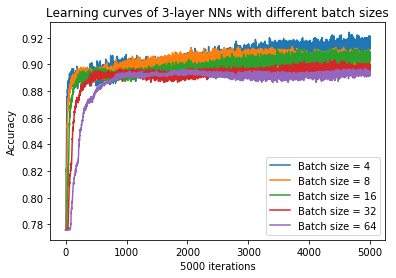

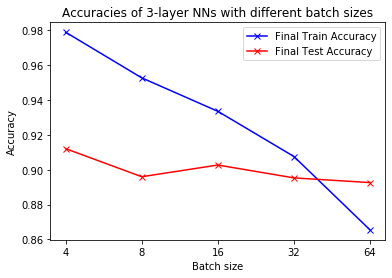

In [16]:
# Plot accuracy
final_train_acc = []
final_test_acc = []

fig, ax = plt.subplots()
for idx, batch_size in enumerate(BATCH_SIZES):
    ax.plot(range(epochs), batch_size_test_accs[idx], label="Batch size = " + str(batch_size))
    print("Batch size {} reached train accuracy of {} and test accuracy of {} after 5000 epochs."
          .format(batch_size, batch_size_train_accs[idx][-1], batch_size_test_accs[idx][-1]))
    
    final_train_acc.append(batch_size_train_accs[idx][-1])
    final_test_acc.append(batch_size_test_accs[idx][-1])
legend = ax.legend(loc='lower right')

plt.xlabel(str(epochs) +' iterations')
plt.ylabel('Accuracy')
plt.title('Learning curves of 3-layer NNs with different batch sizes')
plt.savefig('figures/project_1a_q2a_1.png')
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot([str(batch_size) for batch_size in BATCH_SIZES], final_train_acc, 'xb-', label="Final Train Accuracy")
ax2.plot([str(batch_size) for batch_size in BATCH_SIZES], final_test_acc, 'xr-', label="Final Test Accuracy")
legend = ax2.legend(loc='upper right')

plt.xlabel('Batch size')
plt.ylabel('Accuracy')
plt.title('Accuracies of 3-layer NNs with different batch sizes')
plt.savefig('figures/project_1a_q2a_2.png')
plt.show()

Batch size 4 reached a loss of 0.09828034788370132 after 5000 epochs.
Batch size 8 reached a loss of 0.13014288246631622 after 5000 epochs.
Batch size 16 reached a loss of 0.14286653697490692 after 5000 epochs.
Batch size 32 reached a loss of 0.1577199548482895 after 5000 epochs.
Batch size 64 reached a loss of 0.18796738982200623 after 5000 epochs.


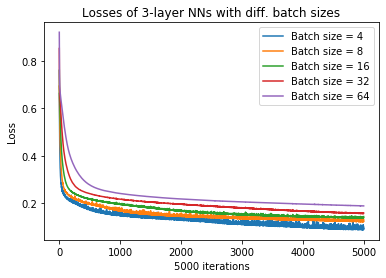

In [17]:
# Plot loss
fig, ax = plt.subplots()
for idx, batch_size in enumerate(BATCH_SIZES):
    ax.plot(range(epochs), batch_losses[idx], label="Batch size = " + str(batch_size))
    print("Batch size {} reached a loss of {} after 5000 epochs.".format(batch_size, batch_losses[idx][-1]))
legend = ax.legend(loc='upper right')

plt.xlabel(str(epochs) +' iterations')
plt.ylabel('Loss')
plt.title('Losses of 3-layer NNs with diff. batch sizes')
plt.savefig('figures/project_1a_q2a_3.png')
plt.show()

[0.15038504219055177, 0.07724877579689027, 0.04148065863609314, 0.02125099762916565, 0.012074809551239013]


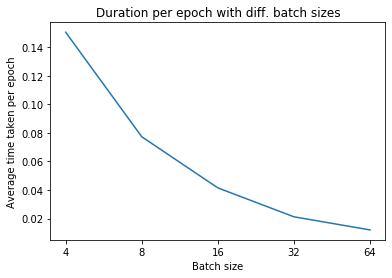

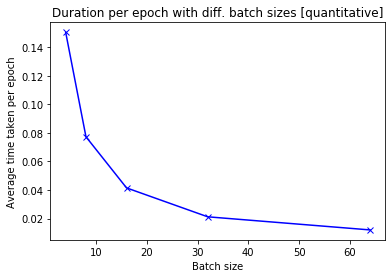

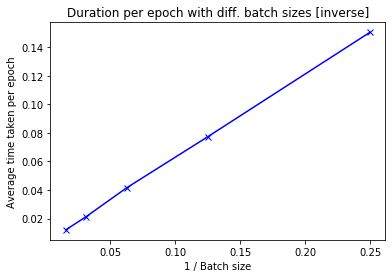

In [32]:
# Plot the time taken
print(batch_times)
plt.plot([str(batch_size) for batch_size in BATCH_SIZES], batch_times)
plt.xlabel('Batch size')
plt.ylabel('Average time taken per epoch')
plt.title('Duration per epoch with diff. batch sizes')
plt.savefig('figures/project_1a_q2a_4.png')
plt.show()

plt.plot(BATCH_SIZES, batch_times, 'xb-')
plt.xlabel('Batch size')
plt.ylabel('Average time taken per epoch')
plt.title('Duration per epoch with diff. batch sizes [quantitative]')
plt.savefig('figures/project_1a_q2a_5.png')
plt.show()

plt.plot([1 / batch_size for batch_size in BATCH_SIZES], batch_times, 'xb-')
plt.xlabel('1 / Batch size')
plt.ylabel('Average time taken per epoch')
plt.title('Duration per epoch with diff. batch sizes [inverse]')
plt.savefig('figures/project_1a_q2a_6.png')
plt.show()

iter 0: accuracy 0.767287, test accuracy 0.784591, loss 0.733193
iter 100: accuracy 0.878989, test accuracy 0.894654, loss 0.276917
iter 200: accuracy 0.890957, test accuracy 0.899371, loss 0.242159
iter 300: accuracy 0.894282, test accuracy 0.904088, loss 0.229441
iter 400: accuracy 0.896277, test accuracy 0.907233, loss 0.220842
iter 500: accuracy 0.896277, test accuracy 0.908805, loss 0.218185
iter 600: accuracy 0.900266, test accuracy 0.91195, loss 0.208758
iter 700: accuracy 0.899601, test accuracy 0.91195, loss 0.203932
iter 800: accuracy 0.904255, test accuracy 0.91195, loss 0.200252
iter 900: accuracy 0.905585, test accuracy 0.90566, loss 0.195248
iter 1000: accuracy 0.90492, test accuracy 0.900943, loss 0.194982
iter 1100: accuracy 0.910904, test accuracy 0.916667, loss 0.188885
iter 1200: accuracy 0.910239, test accuracy 0.904088, loss 0.183435
iter 1300: accuracy 0.912899, test accuracy 0.915094, loss 0.180174
iter 1400: accuracy 0.913564, test accuracy 0.918239, loss 0.1839

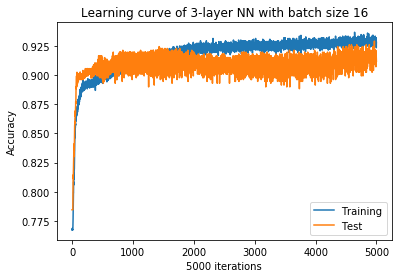

In [19]:
# Train with optimal batch size
OPTIMAL_BATCH_SIZE = 16

train_acc, test_acc, loss = training(cv_and_trainX, cv_and_trainY, num_classes=10, decay_parameter=10 ** -6,
                                     batch_size=OPTIMAL_BATCH_SIZE, no_of_layers=3, testX=testX, testY=testY,
                                     use_small_dataset=False)

# Plot learning curves
print('Final training accuracy is {}'.format(train_acc[-1]))
print('Final test accuracy is {}'.format(test_acc[-1]))
print('Final loss is {}'.format(loss[-1]))

fig, ax = plt.subplots()
ax.plot(range(epochs), train_acc, label='Training')
ax.plot(range(epochs), test_acc, label='Test')
legend = ax.legend(loc='lower right')

plt.xlabel(str(epochs) +' iterations')
plt.ylabel('Accuracy')
plt.title('Learning curve of 3-layer NN with batch size {}'.format(OPTIMAL_BATCH_SIZE))
plt.savefig('figures/project_1a_q2c.png')
plt.show()

In [20]:
# QUESTION 3
# Optimal number of hidden-layer neurons

NEURON_NUMS = [5, 10, 15, 20, 25]

num_neuron_train_accs = []
num_neuron_test_accs = []
num_neuron_losses = []

# Try training with different batch sizes
for neuron_num in NEURON_NUMS:
    print("==============")
    print("USING {} NUMBER OF NEURONS IN HIDDEN LAYER".format(neuron_num))
    print("==============")
    train_accs = []
    cross_validation_accs = []
    losses = []
    
    # Further split trainX and trainY to do 5-fold cross-validation
    for fold in range(5):
        print("==============")
        print("FOLD {}".format(fold + 1))
        print("==============")

        # Find indexes to split dataset further.
        start_idx = fold * int(idx_split / 5)
        end_idx = (fold + 1) * int(idx_split / 5)

        # Split training dataset further to training and test set.
        trainX = np.append(cv_and_trainX[:start_idx], cv_and_trainX[end_idx:], axis=0)
        trainY = np.append(cv_and_trainY[:start_idx], cv_and_trainY[end_idx:], axis=0)
        cv_X = cv_and_trainX[start_idx:end_idx]
        cv_Y = cv_and_trainY[start_idx:end_idx]

        # Train the model.
        train_acc, cv_acc, loss = training(trainX, trainY, num_classes=neuron_num, decay_parameter=10 ** -6,
                                           batch_size=OPTIMAL_BATCH_SIZE, no_of_layers=3, testX=cv_X, testY=cv_Y,
                                           use_small_dataset=False)
        
        # Record cross-validation accuracies of model
        train_accs.append(train_acc)
        cross_validation_accs.append(cv_acc)
        losses.append(loss)

    # Find mean model training accuracies per epoch and average time taken for differnt batch sizes.
    model_train_accs_avg = np.average(np.array(train_accs), axis=0).tolist()
    model_test_accs_avg = np.average(np.array(cross_validation_accs), axis=0).tolist()
    num_neuron_loss_avg = np.average(np.array(losses), axis=0).tolist()
    
    num_neuron_train_accs.append(model_train_accs_avg)
    num_neuron_test_accs.append(model_test_accs_avg)
    num_neuron_losses.append(num_neuron_loss_avg)

USING 5 NUMBER OF NEURONS IN HIDDEN LAYER
FOLD 1
iter 0: accuracy 0.761667, test accuracy 0.791946, loss 0.762852
iter 100: accuracy 0.868333, test accuracy 0.885906, loss 0.290855
iter 200: accuracy 0.886667, test accuracy 0.895973, loss 0.252301
iter 300: accuracy 0.8875, test accuracy 0.895973, loss 0.239949
iter 400: accuracy 0.893333, test accuracy 0.889262, loss 0.232956
iter 500: accuracy 0.8875, test accuracy 0.892617, loss 0.227892
iter 600: accuracy 0.893333, test accuracy 0.895973, loss 0.224318
iter 700: accuracy 0.895, test accuracy 0.892617, loss 0.222403
iter 800: accuracy 0.8975, test accuracy 0.889262, loss 0.220414
iter 900: accuracy 0.895, test accuracy 0.895973, loss 0.216006
iter 1000: accuracy 0.901667, test accuracy 0.889262, loss 0.215038
iter 1100: accuracy 0.905833, test accuracy 0.892617, loss 0.211809
iter 1200: accuracy 0.898333, test accuracy 0.899329, loss 0.20959
iter 1300: accuracy 0.900833, test accuracy 0.895973, loss 0.207917
iter 1400: accuracy 0.90

iter 2000: accuracy 0.915, test accuracy 0.895973, loss 0.185374
iter 2100: accuracy 0.915833, test accuracy 0.895973, loss 0.185426
iter 2200: accuracy 0.9075, test accuracy 0.895973, loss 0.183499
iter 2300: accuracy 0.910833, test accuracy 0.899329, loss 0.182446
iter 2400: accuracy 0.914167, test accuracy 0.892617, loss 0.181003
iter 2500: accuracy 0.913333, test accuracy 0.899329, loss 0.188175
iter 2600: accuracy 0.910833, test accuracy 0.895973, loss 0.179887
iter 2700: accuracy 0.911667, test accuracy 0.895973, loss 0.179281
iter 2800: accuracy 0.916667, test accuracy 0.895973, loss 0.178799
iter 2900: accuracy 0.916667, test accuracy 0.889262, loss 0.183942
iter 3000: accuracy 0.916667, test accuracy 0.902685, loss 0.179772
iter 3100: accuracy 0.9125, test accuracy 0.899329, loss 0.176411
iter 3200: accuracy 0.915833, test accuracy 0.895973, loss 0.176631
iter 3300: accuracy 0.916667, test accuracy 0.895973, loss 0.17613
iter 3400: accuracy 0.920833, test accuracy 0.902685, lo

iter 4200: accuracy 0.905833, test accuracy 0.919463, loss 0.206168
iter 4300: accuracy 0.9075, test accuracy 0.90604, loss 0.211026
iter 4400: accuracy 0.905, test accuracy 0.909396, loss 0.206493
iter 4500: accuracy 0.898333, test accuracy 0.922819, loss 0.204781
iter 4600: accuracy 0.900833, test accuracy 0.926175, loss 0.204445
iter 4700: accuracy 0.9, test accuracy 0.922819, loss 0.205074
iter 4800: accuracy 0.9075, test accuracy 0.922819, loss 0.20425
iter 4900: accuracy 0.899167, test accuracy 0.90604, loss 0.2065
USING 10 NUMBER OF NEURONS IN HIDDEN LAYER
FOLD 1
iter 0: accuracy 0.761667, test accuracy 0.791946, loss 0.766955
iter 100: accuracy 0.864167, test accuracy 0.869128, loss 0.295839
iter 200: accuracy 0.883333, test accuracy 0.895973, loss 0.252036
iter 300: accuracy 0.886667, test accuracy 0.895973, loss 0.23772
iter 400: accuracy 0.888333, test accuracy 0.892617, loss 0.228268
iter 500: accuracy 0.894167, test accuracy 0.892617, loss 0.220372
iter 600: accuracy 0.897

iter 1300: accuracy 0.8975, test accuracy 0.916107, loss 0.190458
iter 1400: accuracy 0.9075, test accuracy 0.916107, loss 0.1875
iter 1500: accuracy 0.905833, test accuracy 0.92953, loss 0.191457
iter 1600: accuracy 0.905833, test accuracy 0.90604, loss 0.184576
iter 1700: accuracy 0.9075, test accuracy 0.899329, loss 0.186214
iter 1800: accuracy 0.908333, test accuracy 0.912752, loss 0.177196
iter 1900: accuracy 0.905833, test accuracy 0.922819, loss 0.175768
iter 2000: accuracy 0.9125, test accuracy 0.902685, loss 0.174916
iter 2100: accuracy 0.9075, test accuracy 0.90604, loss 0.17403
iter 2200: accuracy 0.913333, test accuracy 0.899329, loss 0.1749
iter 2300: accuracy 0.914167, test accuracy 0.916107, loss 0.170817
iter 2400: accuracy 0.915833, test accuracy 0.922819, loss 0.169304
iter 2500: accuracy 0.915, test accuracy 0.922819, loss 0.187659
iter 2600: accuracy 0.915833, test accuracy 0.919463, loss 0.16779
iter 2700: accuracy 0.9125, test accuracy 0.922819, loss 0.167435
iter

iter 3600: accuracy 0.929167, test accuracy 0.899329, loss 0.146895
iter 3700: accuracy 0.930833, test accuracy 0.902685, loss 0.147614
iter 3800: accuracy 0.93, test accuracy 0.909396, loss 0.148501
iter 3900: accuracy 0.931667, test accuracy 0.902685, loss 0.145651
iter 4000: accuracy 0.933333, test accuracy 0.902685, loss 0.14406
iter 4100: accuracy 0.9325, test accuracy 0.902685, loss 0.143944
iter 4200: accuracy 0.934167, test accuracy 0.902685, loss 0.143118
iter 4300: accuracy 0.933333, test accuracy 0.902685, loss 0.143334
iter 4400: accuracy 0.936667, test accuracy 0.90604, loss 0.143121
iter 4500: accuracy 0.931667, test accuracy 0.902685, loss 0.140455
iter 4600: accuracy 0.934167, test accuracy 0.90604, loss 0.13982
iter 4700: accuracy 0.93, test accuracy 0.912752, loss 0.142131
iter 4800: accuracy 0.935, test accuracy 0.909396, loss 0.141667
iter 4900: accuracy 0.931667, test accuracy 0.902685, loss 0.140009
USING 15 NUMBER OF NEURONS IN HIDDEN LAYER
FOLD 1
iter 0: accurac

iter 700: accuracy 0.896667, test accuracy 0.912752, loss 0.206679
iter 800: accuracy 0.900833, test accuracy 0.916107, loss 0.199698
iter 900: accuracy 0.903333, test accuracy 0.916107, loss 0.194252
iter 1000: accuracy 0.908333, test accuracy 0.909396, loss 0.188929
iter 1100: accuracy 0.9125, test accuracy 0.919463, loss 0.186776
iter 1200: accuracy 0.913333, test accuracy 0.912752, loss 0.181809
iter 1300: accuracy 0.91, test accuracy 0.90604, loss 0.178387
iter 1400: accuracy 0.915833, test accuracy 0.902685, loss 0.176512
iter 1500: accuracy 0.915, test accuracy 0.909396, loss 0.177375
iter 1600: accuracy 0.916667, test accuracy 0.899329, loss 0.171991
iter 1700: accuracy 0.919167, test accuracy 0.902685, loss 0.175354
iter 1800: accuracy 0.920833, test accuracy 0.902685, loss 0.165629
iter 1900: accuracy 0.919167, test accuracy 0.90604, loss 0.164322
iter 2000: accuracy 0.926667, test accuracy 0.90604, loss 0.162435
iter 2100: accuracy 0.918333, test accuracy 0.895973, loss 0.16

iter 2900: accuracy 0.93, test accuracy 0.916107, loss 0.143701
iter 3000: accuracy 0.934167, test accuracy 0.90604, loss 0.149422
iter 3100: accuracy 0.935, test accuracy 0.916107, loss 0.139164
iter 3200: accuracy 0.933333, test accuracy 0.916107, loss 0.138939
iter 3300: accuracy 0.938333, test accuracy 0.916107, loss 0.136196
iter 3400: accuracy 0.936667, test accuracy 0.916107, loss 0.134407
iter 3500: accuracy 0.9375, test accuracy 0.912752, loss 0.132537
iter 3600: accuracy 0.938333, test accuracy 0.912752, loss 0.13144
iter 3700: accuracy 0.94, test accuracy 0.916107, loss 0.132917
iter 3800: accuracy 0.94, test accuracy 0.90604, loss 0.133412
iter 3900: accuracy 0.9425, test accuracy 0.909396, loss 0.136823
iter 4000: accuracy 0.941667, test accuracy 0.912752, loss 0.124979
iter 4100: accuracy 0.944167, test accuracy 0.912752, loss 0.124105
iter 4200: accuracy 0.944167, test accuracy 0.902685, loss 0.123791
iter 4300: accuracy 0.9475, test accuracy 0.90604, loss 0.124119
iter 

FOLD 3
iter 0: accuracy 0.76, test accuracy 0.798658, loss 0.752756
iter 100: accuracy 0.874167, test accuracy 0.872483, loss 0.28541
iter 200: accuracy 0.889167, test accuracy 0.892617, loss 0.247525
iter 300: accuracy 0.890833, test accuracy 0.895973, loss 0.232697
iter 400: accuracy 0.899167, test accuracy 0.90604, loss 0.222576
iter 500: accuracy 0.895833, test accuracy 0.902685, loss 0.214458
iter 600: accuracy 0.895833, test accuracy 0.895973, loss 0.207195
iter 700: accuracy 0.9, test accuracy 0.90604, loss 0.201538
iter 800: accuracy 0.9025, test accuracy 0.909396, loss 0.194633
iter 900: accuracy 0.905833, test accuracy 0.90604, loss 0.189288
iter 1000: accuracy 0.905833, test accuracy 0.899329, loss 0.184435
iter 1100: accuracy 0.910833, test accuracy 0.912752, loss 0.181976
iter 1200: accuracy 0.913333, test accuracy 0.902685, loss 0.176127
iter 1300: accuracy 0.914167, test accuracy 0.892617, loss 0.172366
iter 1400: accuracy 0.918333, test accuracy 0.899329, loss 0.169617


iter 2200: accuracy 0.934167, test accuracy 0.90604, loss 0.148188
iter 2300: accuracy 0.9275, test accuracy 0.90604, loss 0.147272
iter 2400: accuracy 0.933333, test accuracy 0.90604, loss 0.144985
iter 2500: accuracy 0.934167, test accuracy 0.909396, loss 0.149761
iter 2600: accuracy 0.9325, test accuracy 0.909396, loss 0.142385
iter 2700: accuracy 0.934167, test accuracy 0.90604, loss 0.141177
iter 2800: accuracy 0.934167, test accuracy 0.909396, loss 0.141813
iter 2900: accuracy 0.93, test accuracy 0.909396, loss 0.138208
iter 3000: accuracy 0.935833, test accuracy 0.912752, loss 0.145168
iter 3100: accuracy 0.9325, test accuracy 0.909396, loss 0.135148
iter 3200: accuracy 0.934167, test accuracy 0.909396, loss 0.136069
iter 3300: accuracy 0.935, test accuracy 0.909396, loss 0.133103
iter 3400: accuracy 0.936667, test accuracy 0.912752, loss 0.130968
iter 3500: accuracy 0.9325, test accuracy 0.912752, loss 0.129903
iter 3600: accuracy 0.935833, test accuracy 0.912752, loss 0.128079

iter 4300: accuracy 0.954167, test accuracy 0.912752, loss 0.114007
iter 4400: accuracy 0.9525, test accuracy 0.916107, loss 0.107215
iter 4500: accuracy 0.951667, test accuracy 0.916107, loss 0.106568
iter 4600: accuracy 0.951667, test accuracy 0.916107, loss 0.104827
iter 4700: accuracy 0.955, test accuracy 0.922819, loss 0.103325
iter 4800: accuracy 0.951667, test accuracy 0.926175, loss 0.102501
iter 4900: accuracy 0.954167, test accuracy 0.919463, loss 0.101587
FOLD 3
iter 0: accuracy 0.760833, test accuracy 0.798658, loss 0.698139
iter 100: accuracy 0.878333, test accuracy 0.879195, loss 0.275086
iter 200: accuracy 0.891667, test accuracy 0.88255, loss 0.244943
iter 300: accuracy 0.891667, test accuracy 0.892617, loss 0.232715
iter 400: accuracy 0.8975, test accuracy 0.90604, loss 0.224259
iter 500: accuracy 0.894167, test accuracy 0.899329, loss 0.216907
iter 600: accuracy 0.896667, test accuracy 0.895973, loss 0.210127
iter 700: accuracy 0.899167, test accuracy 0.909396, loss 0

iter 1500: accuracy 0.923333, test accuracy 0.909396, loss 0.173567
iter 1600: accuracy 0.925, test accuracy 0.919463, loss 0.16134
iter 1700: accuracy 0.926667, test accuracy 0.909396, loss 0.158512
iter 1800: accuracy 0.930833, test accuracy 0.909396, loss 0.155422
iter 1900: accuracy 0.925, test accuracy 0.912752, loss 0.153754
iter 2000: accuracy 0.928333, test accuracy 0.909396, loss 0.150191
iter 2100: accuracy 0.93, test accuracy 0.916107, loss 0.148232
iter 2200: accuracy 0.934167, test accuracy 0.909396, loss 0.147626
iter 2300: accuracy 0.928333, test accuracy 0.912752, loss 0.144668
iter 2400: accuracy 0.936667, test accuracy 0.912752, loss 0.141767
iter 2500: accuracy 0.9325, test accuracy 0.90604, loss 0.147048
iter 2600: accuracy 0.936667, test accuracy 0.909396, loss 0.137731
iter 2700: accuracy 0.9375, test accuracy 0.909396, loss 0.135643
iter 2800: accuracy 0.938333, test accuracy 0.90604, loss 0.138671
iter 2900: accuracy 0.9375, test accuracy 0.916107, loss 0.132775

Neural network with 5 hidden units reached train accuracy of 0.9194999999999995 and test accuracy of 0.8953019976615906 after 5000 epochs.
Neural network with 10 hidden units reached train accuracy of 0.9334999999999992 and test accuracy of 0.9026845097541809 after 5000 epochs.
Neural network with 15 hidden units reached train accuracy of 0.9396666666666661 and test accuracy of 0.9013422727584839 after 5000 epochs.
Neural network with 20 hidden units reached train accuracy of 0.9551666666666657 and test accuracy of 0.910067081451416 after 5000 epochs.
Neural network with 25 hidden units reached train accuracy of 0.9561666666666655 and test accuracy of 0.9134227633476257 after 5000 epochs.


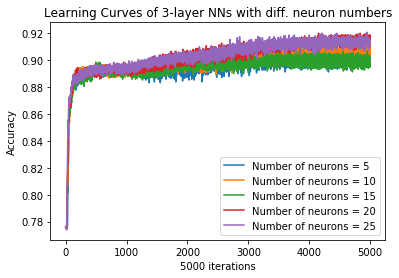

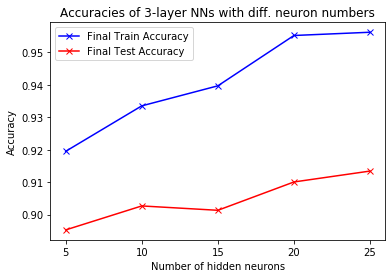

In [21]:
# Plot accuracies
final_train_acc = []
final_test_acc = []

fig, ax = plt.subplots()
for idx, neuron_num in enumerate(NEURON_NUMS):
    ax.plot(range(epochs), num_neuron_test_accs[idx], label="Number of neurons = " + str(neuron_num))
    print("Neural network with {} hidden units reached train accuracy of {} and test accuracy of {} after 5000 epochs."
          .format(neuron_num, num_neuron_train_accs[idx][-1], num_neuron_test_accs[idx][-1]))
    
    final_train_acc.append(num_neuron_train_accs[idx][-1])
    final_test_acc.append(num_neuron_test_accs[idx][-1])
legend = ax.legend(loc='lower right')

plt.xlabel(str(epochs) +' iterations')
plt.ylabel('Accuracy')
plt.title('Learning Curves of 3-layer NNs with diff. neuron numbers')
plt.savefig('figures/project_1a_q3a_1.png')
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot([str(neuron_num) for neuron_num in NEURON_NUMS], final_train_acc, 'xb-', label="Final Train Accuracy")
ax2.plot([str(neuron_num) for neuron_num in NEURON_NUMS], final_test_acc, 'xr-', label="Final Test Accuracy")
legend = ax2.legend(loc='upper left')

plt.xlabel('Number of hidden neurons')
plt.ylabel('Accuracy')
plt.title('Accuracies of 3-layer NNs with diff. neuron numbers')
plt.savefig('figures/project_1a_q3a_2.png')
plt.show()

Neural network with 5 hidden units has loss 0.1725901961326599 after 5000 epochs.
Neural network with 10 hidden units has loss 0.14286653697490692 after 5000 epochs.
Neural network with 15 hidden units has loss 0.13360503315925598 after 5000 epochs.
Neural network with 20 hidden units has loss 0.10293909162282944 after 5000 epochs.
Neural network with 25 hidden units has loss 0.10241242498159409 after 5000 epochs.


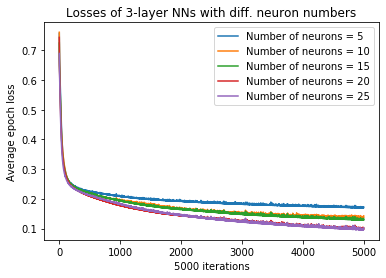

In [22]:
# Plot loss
fig, ax = plt.subplots()
for idx, neuron_num in enumerate(NEURON_NUMS):
    ax.plot(range(epochs), num_neuron_losses[idx], label="Number of neurons = " + str(neuron_num))
    print("Neural network with {} hidden units has loss {} after 5000 epochs.".format(neuron_num, num_neuron_losses[idx][-1]))
legend = ax.legend(loc='upper right')

plt.xlabel(str(epochs) +' iterations')
plt.ylabel('Average epoch loss')
plt.title('Losses of 3-layer NNs with diff. neuron numbers')
plt.savefig('figures/project_1a_q3a_3.png')
plt.show()

iter 0: accuracy 0.767287, test accuracy 0.784591, loss 0.673617
iter 100: accuracy 0.883644, test accuracy 0.896226, loss 0.262673
iter 200: accuracy 0.894282, test accuracy 0.908805, loss 0.23497
iter 300: accuracy 0.898271, test accuracy 0.900943, loss 0.224149
iter 400: accuracy 0.902261, test accuracy 0.902516, loss 0.214968
iter 500: accuracy 0.901596, test accuracy 0.902516, loss 0.211563
iter 600: accuracy 0.901596, test accuracy 0.907233, loss 0.200713
iter 700: accuracy 0.906915, test accuracy 0.91195, loss 0.194205
iter 800: accuracy 0.909574, test accuracy 0.91195, loss 0.187632
iter 900: accuracy 0.915559, test accuracy 0.918239, loss 0.180764
iter 1000: accuracy 0.916888, test accuracy 0.90566, loss 0.182323
iter 1100: accuracy 0.925532, test accuracy 0.919811, loss 0.171339
iter 1200: accuracy 0.926862, test accuracy 0.922956, loss 0.163092
iter 1300: accuracy 0.929521, test accuracy 0.922956, loss 0.158266
iter 1400: accuracy 0.93484, test accuracy 0.921384, loss 0.1598

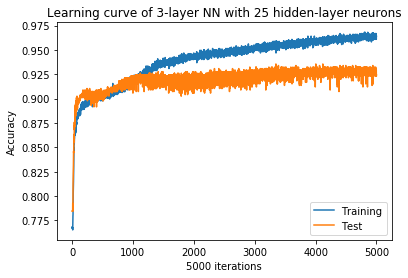

In [23]:
# Train with optimal batch size and number of neurons
OPTIMAL_NEURON_NUM = 25

train_acc, test_acc, loss = training(cv_and_trainX, cv_and_trainY, num_classes=OPTIMAL_NEURON_NUM, decay_parameter=10 ** -6,
                                     batch_size=OPTIMAL_BATCH_SIZE, no_of_layers=3, testX=testX, testY=testY,
                                     use_small_dataset=False)

# Plot learning curves
print('Final training accuracy is {}'.format(train_acc[-1]))
print('Final test accuracy is {}'.format(test_acc[-1]))
print('Final loss is {}'.format(loss[-1]))

fig, ax = plt.subplots()
ax.plot(range(epochs), train_acc, label='Training')
ax.plot(range(epochs), test_acc, label='Test')
legend = ax.legend(loc='lower right')

plt.xlabel(str(epochs) +' iterations')
plt.ylabel('Accuracy')
plt.title('Learning curve of 3-layer NN with {} hidden-layer neurons'.format(OPTIMAL_NEURON_NUM))
plt.savefig('figures/project_1a_q3c.png')
plt.show()

In [24]:
# QUESTION 4
# Optimal decay parameter

DECAY_PARAMETERS = [0, 10 ** -3, 10 ** -6, 10 ** -9, 10 ** -12]

decay_parameter_train_accs = []
decay_parameter_test_accs = []
decay_parameter_losses = []

# Try training with different batch sizes
for decay_parameter in DECAY_PARAMETERS:
    print("==============")
    print("USING DECAY PARAMETER = {}".format(decay_parameter))
    print("==============")
    train_accs = []
    cross_validation_accs = []
    losses = []
    
    # Further split trainX and trainY to do 5-fold cross-validation
    for fold in range(5):
        print("==============")
        print("FOLD {}".format(fold + 1))
        print("==============")

        # Find indexes to split dataset further.
        start_idx = fold * int(idx_split / 5)
        end_idx = (fold + 1) * int(idx_split / 5)

        # Split training dataset further to training and test set.
        trainX = np.append(cv_and_trainX[:start_idx], cv_and_trainX[end_idx:], axis=0)
        trainY = np.append(cv_and_trainY[:start_idx], cv_and_trainY[end_idx:], axis=0)
        cv_X = cv_and_trainX[start_idx:end_idx]
        cv_Y = cv_and_trainY[start_idx:end_idx]

        # Train the model.
        train_acc, cv_acc, loss = training(trainX, trainY, num_classes=OPTIMAL_NEURON_NUM, decay_parameter=decay_parameter,
                                           batch_size=OPTIMAL_BATCH_SIZE, no_of_layers=3, testX=cv_X, testY=cv_Y,
                                           use_small_dataset=False)
        
        # Record cross-validation accuracies of model
        train_accs.append(train_acc)
        cross_validation_accs.append(cv_acc)
        losses.append(loss)

    # Find mean model training accuracies per epoch and average time taken for differnt batch sizes.
    model_train_accs_avg = np.average(np.array(train_accs), axis=0).tolist()
    model_test_accs_avg = np.average(np.array(cross_validation_accs), axis=0).tolist()
    decay_parameter_loss_avg = np.average(np.array(losses), axis=0).tolist()
    
    decay_parameter_train_accs.append(model_train_accs_avg)
    decay_parameter_test_accs.append(model_test_accs_avg)
    decay_parameter_losses.append(decay_parameter_loss_avg)

USING DECAY PARAMETER = 0
FOLD 1
iter 0: accuracy 0.7625, test accuracy 0.791946, loss 0.693722
iter 100: accuracy 0.871667, test accuracy 0.892617, loss 0.275643
iter 200: accuracy 0.89, test accuracy 0.899329, loss 0.243282
iter 300: accuracy 0.895, test accuracy 0.895973, loss 0.22952
iter 400: accuracy 0.900833, test accuracy 0.899329, loss 0.220933
iter 500: accuracy 0.895, test accuracy 0.899329, loss 0.213559
iter 600: accuracy 0.903333, test accuracy 0.902685, loss 0.207149
iter 700: accuracy 0.9075, test accuracy 0.899329, loss 0.201736
iter 800: accuracy 0.9075, test accuracy 0.902685, loss 0.195865
iter 900: accuracy 0.914167, test accuracy 0.899329, loss 0.189582
iter 1000: accuracy 0.913333, test accuracy 0.895973, loss 0.18502
iter 1100: accuracy 0.914167, test accuracy 0.899329, loss 0.180183
iter 1200: accuracy 0.920833, test accuracy 0.909396, loss 0.174293
iter 1300: accuracy 0.919167, test accuracy 0.90604, loss 0.169947
iter 1400: accuracy 0.920833, test accuracy 0.

iter 2100: accuracy 0.9275, test accuracy 0.909396, loss 0.147386
iter 2200: accuracy 0.930833, test accuracy 0.90604, loss 0.146284
iter 2300: accuracy 0.931667, test accuracy 0.909396, loss 0.141431
iter 2400: accuracy 0.929167, test accuracy 0.90604, loss 0.138974
iter 2500: accuracy 0.936667, test accuracy 0.942953, loss 0.152611
iter 2600: accuracy 0.930833, test accuracy 0.909396, loss 0.135019
iter 2700: accuracy 0.936667, test accuracy 0.909396, loss 0.132864
iter 2800: accuracy 0.935, test accuracy 0.909396, loss 0.131443
iter 2900: accuracy 0.9375, test accuracy 0.899329, loss 0.136121
iter 3000: accuracy 0.94, test accuracy 0.922819, loss 0.129206
iter 3100: accuracy 0.940833, test accuracy 0.909396, loss 0.125997
iter 3200: accuracy 0.9425, test accuracy 0.90604, loss 0.127661
iter 3300: accuracy 0.9425, test accuracy 0.909396, loss 0.123421
iter 3400: accuracy 0.938333, test accuracy 0.92953, loss 0.123822
iter 3500: accuracy 0.9425, test accuracy 0.90604, loss 0.119798
it

iter 4300: accuracy 0.945833, test accuracy 0.916107, loss 0.114432
iter 4400: accuracy 0.9475, test accuracy 0.922819, loss 0.113729
iter 4500: accuracy 0.950833, test accuracy 0.926175, loss 0.111633
iter 4600: accuracy 0.951667, test accuracy 0.926175, loss 0.110141
iter 4700: accuracy 0.95, test accuracy 0.916107, loss 0.112001
iter 4800: accuracy 0.948333, test accuracy 0.926175, loss 0.108674
iter 4900: accuracy 0.955, test accuracy 0.919463, loss 0.118321
USING DECAY PARAMETER = 0.001
FOLD 1
iter 0: accuracy 0.7625, test accuracy 0.791946, loss 0.703959
iter 100: accuracy 0.870833, test accuracy 0.885906, loss 0.30126
iter 200: accuracy 0.8875, test accuracy 0.899329, loss 0.274581
iter 300: accuracy 0.895833, test accuracy 0.892617, loss 0.265008
iter 400: accuracy 0.899167, test accuracy 0.899329, loss 0.259647
iter 500: accuracy 0.896667, test accuracy 0.895973, loss 0.25562
iter 600: accuracy 0.900833, test accuracy 0.892617, loss 0.252277
iter 700: accuracy 0.901667, test a

iter 1400: accuracy 0.904167, test accuracy 0.909396, loss 0.239906
iter 1500: accuracy 0.91, test accuracy 0.919463, loss 0.240223
iter 1600: accuracy 0.906667, test accuracy 0.90604, loss 0.238411
iter 1700: accuracy 0.9075, test accuracy 0.909396, loss 0.239183
iter 1800: accuracy 0.905, test accuracy 0.899329, loss 0.235002
iter 1900: accuracy 0.911667, test accuracy 0.912752, loss 0.233593
iter 2000: accuracy 0.91, test accuracy 0.899329, loss 0.232751
iter 2100: accuracy 0.914167, test accuracy 0.899329, loss 0.232537
iter 2200: accuracy 0.914167, test accuracy 0.902685, loss 0.231724
iter 2300: accuracy 0.915833, test accuracy 0.902685, loss 0.230648
iter 2400: accuracy 0.915, test accuracy 0.90604, loss 0.229349
iter 2500: accuracy 0.921667, test accuracy 0.92953, loss 0.236664
iter 2600: accuracy 0.915833, test accuracy 0.909396, loss 0.228291
iter 2700: accuracy 0.918333, test accuracy 0.909396, loss 0.227593
iter 2800: accuracy 0.918333, test accuracy 0.90604, loss 0.227549


iter 3600: accuracy 0.9225, test accuracy 0.916107, loss 0.225247
iter 3700: accuracy 0.921667, test accuracy 0.919463, loss 0.225959
iter 3800: accuracy 0.921667, test accuracy 0.912752, loss 0.228836
iter 3900: accuracy 0.925, test accuracy 0.916107, loss 0.225903
iter 4000: accuracy 0.925833, test accuracy 0.912752, loss 0.224085
iter 4100: accuracy 0.920833, test accuracy 0.919463, loss 0.224245
iter 4200: accuracy 0.924167, test accuracy 0.912752, loss 0.224532
iter 4300: accuracy 0.92, test accuracy 0.912752, loss 0.225084
iter 4400: accuracy 0.9275, test accuracy 0.919463, loss 0.225291
iter 4500: accuracy 0.921667, test accuracy 0.912752, loss 0.222619
iter 4600: accuracy 0.923333, test accuracy 0.912752, loss 0.222272
iter 4700: accuracy 0.924167, test accuracy 0.916107, loss 0.222866
iter 4800: accuracy 0.921667, test accuracy 0.916107, loss 0.222204
iter 4900: accuracy 0.925, test accuracy 0.916107, loss 0.222875
USING DECAY PARAMETER = 1e-06
FOLD 1
iter 0: accuracy 0.7625, 

iter 600: accuracy 0.896667, test accuracy 0.895973, loss 0.210127
iter 700: accuracy 0.899167, test accuracy 0.909396, loss 0.204969
iter 800: accuracy 0.901667, test accuracy 0.90604, loss 0.198214
iter 900: accuracy 0.904167, test accuracy 0.909396, loss 0.192871
iter 1000: accuracy 0.9075, test accuracy 0.895973, loss 0.187153
iter 1100: accuracy 0.911667, test accuracy 0.916107, loss 0.184373
iter 1200: accuracy 0.915833, test accuracy 0.899329, loss 0.177294
iter 1300: accuracy 0.916667, test accuracy 0.899329, loss 0.173087
iter 1400: accuracy 0.919167, test accuracy 0.899329, loss 0.169866
iter 1500: accuracy 0.925833, test accuracy 0.916107, loss 0.167755
iter 1600: accuracy 0.924167, test accuracy 0.899329, loss 0.161796
iter 1700: accuracy 0.924167, test accuracy 0.899329, loss 0.162633
iter 1800: accuracy 0.925833, test accuracy 0.90604, loss 0.154893
iter 1900: accuracy 0.9275, test accuracy 0.912752, loss 0.151363
iter 2000: accuracy 0.93, test accuracy 0.909396, loss 0.1

iter 2800: accuracy 0.938333, test accuracy 0.90604, loss 0.138671
iter 2900: accuracy 0.9375, test accuracy 0.916107, loss 0.132775
iter 3000: accuracy 0.94, test accuracy 0.902685, loss 0.138751
iter 3100: accuracy 0.936667, test accuracy 0.912752, loss 0.128537
iter 3200: accuracy 0.934167, test accuracy 0.916107, loss 0.130662
iter 3300: accuracy 0.941667, test accuracy 0.912752, loss 0.126026
iter 3400: accuracy 0.939167, test accuracy 0.916107, loss 0.1248
iter 3500: accuracy 0.94, test accuracy 0.926175, loss 0.124161
iter 3600: accuracy 0.945833, test accuracy 0.916107, loss 0.121651
iter 3700: accuracy 0.9425, test accuracy 0.926175, loss 0.122022
iter 3800: accuracy 0.946667, test accuracy 0.90604, loss 0.12566
iter 3900: accuracy 0.949167, test accuracy 0.922819, loss 0.120338
iter 4000: accuracy 0.949167, test accuracy 0.919463, loss 0.116869
iter 4100: accuracy 0.95, test accuracy 0.926175, loss 0.115902
iter 4200: accuracy 0.946667, test accuracy 0.912752, loss 0.116964
i

iter 4900: accuracy 0.954167, test accuracy 0.919463, loss 0.101177
FOLD 3
iter 0: accuracy 0.760833, test accuracy 0.798658, loss 0.698129
iter 100: accuracy 0.878333, test accuracy 0.879195, loss 0.275057
iter 200: accuracy 0.891667, test accuracy 0.88255, loss 0.244914
iter 300: accuracy 0.891667, test accuracy 0.892617, loss 0.232689
iter 400: accuracy 0.8975, test accuracy 0.90604, loss 0.22421
iter 500: accuracy 0.893333, test accuracy 0.899329, loss 0.216846
iter 600: accuracy 0.896667, test accuracy 0.895973, loss 0.210071
iter 700: accuracy 0.899167, test accuracy 0.912752, loss 0.204912
iter 800: accuracy 0.901667, test accuracy 0.90604, loss 0.19815
iter 900: accuracy 0.904167, test accuracy 0.90604, loss 0.192842
iter 1000: accuracy 0.9075, test accuracy 0.895973, loss 0.187096
iter 1100: accuracy 0.9125, test accuracy 0.912752, loss 0.184272
iter 1200: accuracy 0.915833, test accuracy 0.899329, loss 0.17722
iter 1300: accuracy 0.916667, test accuracy 0.899329, loss 0.173
i

iter 2100: accuracy 0.93, test accuracy 0.916107, loss 0.148152
iter 2200: accuracy 0.934167, test accuracy 0.909396, loss 0.147546
iter 2300: accuracy 0.928333, test accuracy 0.912752, loss 0.144547
iter 2400: accuracy 0.936667, test accuracy 0.912752, loss 0.141657
iter 2500: accuracy 0.9325, test accuracy 0.90604, loss 0.146963
iter 2600: accuracy 0.935833, test accuracy 0.909396, loss 0.1375
iter 2700: accuracy 0.9375, test accuracy 0.909396, loss 0.135522
iter 2800: accuracy 0.938333, test accuracy 0.90604, loss 0.138611
iter 2900: accuracy 0.9375, test accuracy 0.916107, loss 0.132662
iter 3000: accuracy 0.94, test accuracy 0.90604, loss 0.138772
iter 3100: accuracy 0.936667, test accuracy 0.916107, loss 0.128447
iter 3200: accuracy 0.933333, test accuracy 0.916107, loss 0.130534
iter 3300: accuracy 0.941667, test accuracy 0.912752, loss 0.125899
iter 3400: accuracy 0.939167, test accuracy 0.912752, loss 0.124667
iter 3500: accuracy 0.94, test accuracy 0.926175, loss 0.124019
ite

iter 4200: accuracy 0.955833, test accuracy 0.919463, loss 0.110691
iter 4300: accuracy 0.954167, test accuracy 0.912752, loss 0.113622
iter 4400: accuracy 0.953333, test accuracy 0.916107, loss 0.106826
iter 4500: accuracy 0.951667, test accuracy 0.916107, loss 0.106138
iter 4600: accuracy 0.951667, test accuracy 0.919463, loss 0.104481
iter 4700: accuracy 0.955, test accuracy 0.922819, loss 0.102904
iter 4800: accuracy 0.951667, test accuracy 0.926175, loss 0.10205
iter 4900: accuracy 0.954167, test accuracy 0.916107, loss 0.101237
FOLD 3
iter 0: accuracy 0.760833, test accuracy 0.798658, loss 0.698129
iter 100: accuracy 0.878333, test accuracy 0.879195, loss 0.275057
iter 200: accuracy 0.891667, test accuracy 0.88255, loss 0.244914
iter 300: accuracy 0.891667, test accuracy 0.892617, loss 0.232689
iter 400: accuracy 0.8975, test accuracy 0.90604, loss 0.22421
iter 500: accuracy 0.893333, test accuracy 0.899329, loss 0.216846
iter 600: accuracy 0.896667, test accuracy 0.895973, loss 

iter 1400: accuracy 0.92, test accuracy 0.916107, loss 0.168224
iter 1500: accuracy 0.923333, test accuracy 0.909396, loss 0.173438
iter 1600: accuracy 0.925, test accuracy 0.919463, loss 0.161166
iter 1700: accuracy 0.926667, test accuracy 0.909396, loss 0.158361
iter 1800: accuracy 0.930833, test accuracy 0.909396, loss 0.155272
iter 1900: accuracy 0.925833, test accuracy 0.912752, loss 0.153636
iter 2000: accuracy 0.929167, test accuracy 0.909396, loss 0.150159
iter 2100: accuracy 0.93, test accuracy 0.916107, loss 0.148164
iter 2200: accuracy 0.934167, test accuracy 0.909396, loss 0.147545
iter 2300: accuracy 0.928333, test accuracy 0.912752, loss 0.144551
iter 2400: accuracy 0.9375, test accuracy 0.912752, loss 0.141667
iter 2500: accuracy 0.9325, test accuracy 0.90604, loss 0.146968
iter 2600: accuracy 0.935833, test accuracy 0.909396, loss 0.137549
iter 2700: accuracy 0.9375, test accuracy 0.909396, loss 0.135534
iter 2800: accuracy 0.938333, test accuracy 0.90604, loss 0.138601

Decay parameter = 0 reached train accuracy of 0.9563333333333321 and test accuracy of 0.9114093780517578 after 5000 epochs.
Decay parameter = 0.001 reached train accuracy of 0.9281666666666661 and test accuracy of 0.9093959927558899 after 5000 epochs.
Decay parameter = 1e-06 reached train accuracy of 0.9561666666666655 and test accuracy of 0.9134227633476257 after 5000 epochs.
Decay parameter = 1e-09 reached train accuracy of 0.9564999999999989 and test accuracy of 0.9107381701469421 after 5000 epochs.
Decay parameter = 1e-12 reached train accuracy of 0.9564999999999989 and test accuracy of 0.9120804667472839 after 5000 epochs.


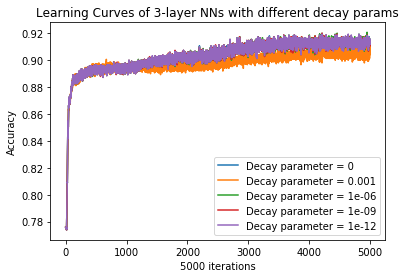

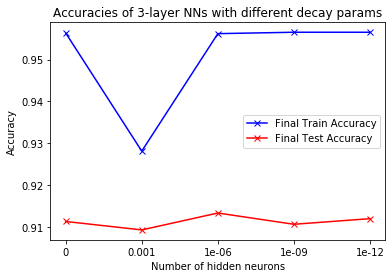

In [25]:
# Plot accuracies
final_train_acc = []
final_test_acc = []

fig, ax = plt.subplots()
for idx, decay_parameter in enumerate(DECAY_PARAMETERS):
    ax.plot(range(epochs), decay_parameter_test_accs[idx], label="Decay parameter = " + str(decay_parameter))
    print("Decay parameter = {} reached train accuracy of {} and test accuracy of {} after 5000 epochs."
          .format(decay_parameter, decay_parameter_train_accs[idx][-1], decay_parameter_test_accs[idx][-1]))
    
    final_train_acc.append(decay_parameter_train_accs[idx][-1])
    final_test_acc.append(decay_parameter_test_accs[idx][-1])
legend = ax.legend(loc='lower right')

plt.xlabel(str(epochs) +' iterations')
plt.ylabel('Accuracy')
plt.title('Learning Curves of 3-layer NNs with different decay params')
plt.savefig('figures/project_1a_q4a_1.png')
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot([str(decay_parameter) for decay_parameter in DECAY_PARAMETERS], final_train_acc, 'xb-', label="Final Train Accuracy")
ax2.plot([str(decay_parameter) for decay_parameter in DECAY_PARAMETERS], final_test_acc, 'xr-', label="Final Test Accuracy")
legend = ax2.legend(loc='center right')

plt.xlabel('Number of hidden neurons')
plt.ylabel('Accuracy')
plt.title('Accuracies of 3-layer NNs with different decay params')
plt.savefig('figures/project_1a_q4a_2.png')
plt.show()

Decay parameter = 0 has loss 0.10259853303432465 after 5000 epochs.
Decay parameter = 0.001 has loss 0.21814048290252686 after 5000 epochs.
Decay parameter = 1e-06 has loss 0.10241242498159409 after 5000 epochs.
Decay parameter = 1e-09 has loss 0.10240670293569565 after 5000 epochs.
Decay parameter = 1e-12 has loss 0.10261049121618271 after 5000 epochs.


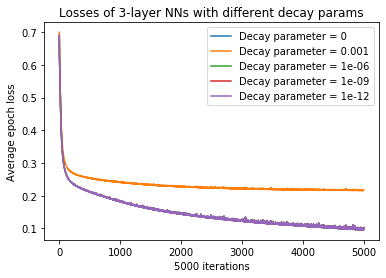

In [26]:
# Plot loss
fig, ax = plt.subplots()
for idx, decay_parameter in enumerate(DECAY_PARAMETERS):
    print("Decay parameter = {} has loss {} after 5000 epochs.".format(decay_parameter, decay_parameter_losses[idx][-1]))
    ax.plot(range(epochs), decay_parameter_losses[idx], label="Decay parameter = " + str(decay_parameter))
legend = ax.legend(loc='upper right')

plt.xlabel(str(epochs) +' iterations')
plt.ylabel('Average epoch loss')
plt.title('Losses of 3-layer NNs with different decay params')
plt.savefig('figures/project_1a_q4a_3.png')
plt.show()

iter 0: accuracy 0.767287, test accuracy 0.784591, loss 0.673617
iter 100: accuracy 0.883644, test accuracy 0.896226, loss 0.262673
iter 200: accuracy 0.894282, test accuracy 0.908805, loss 0.23497
iter 300: accuracy 0.898271, test accuracy 0.900943, loss 0.224149
iter 400: accuracy 0.902261, test accuracy 0.902516, loss 0.214968
iter 500: accuracy 0.901596, test accuracy 0.902516, loss 0.211563
iter 600: accuracy 0.901596, test accuracy 0.907233, loss 0.200713
iter 700: accuracy 0.906915, test accuracy 0.91195, loss 0.194205
iter 800: accuracy 0.909574, test accuracy 0.91195, loss 0.187632
iter 900: accuracy 0.915559, test accuracy 0.918239, loss 0.180764
iter 1000: accuracy 0.916888, test accuracy 0.90566, loss 0.182323
iter 1100: accuracy 0.925532, test accuracy 0.919811, loss 0.171339
iter 1200: accuracy 0.926862, test accuracy 0.922956, loss 0.163092
iter 1300: accuracy 0.929521, test accuracy 0.922956, loss 0.158266
iter 1400: accuracy 0.93484, test accuracy 0.921384, loss 0.1598

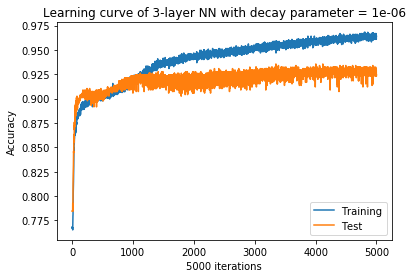

In [27]:
# Train with optimal batch size and number of neurons
OPTIMAL_DECAY_PARAMETER = 10 ** -6

train_acc, test_acc, loss = training(cv_and_trainX, cv_and_trainY, num_classes=OPTIMAL_NEURON_NUM,
                                     decay_parameter=OPTIMAL_DECAY_PARAMETER, batch_size=OPTIMAL_BATCH_SIZE,
                                     no_of_layers=3, testX=testX, testY=testY, use_small_dataset=False)

# Plot learning curves
print('Final training accuracy is {}'.format(train_acc[-1]))
print('Final test accuracy is {}'.format(test_acc[-1]))
print('Final loss is {}'.format(loss[-1]))

fig, ax = plt.subplots()
ax.plot(range(epochs), train_acc, label='Training')
ax.plot(range(epochs), test_acc, label='Test')
legend = ax.legend(loc='lower right')

plt.xlabel(str(epochs) +' iterations')
plt.ylabel('Accuracy')
plt.title('Learning curve of 3-layer NN with decay parameter = {}'.format(OPTIMAL_DECAY_PARAMETER))
plt.savefig('figures/project_1a_q4c.png')
plt.show()

In [28]:
# QUESTION 5
# 4-layer neuron
train_acc_4, test_acc_4, loss_4 = training(cv_and_trainX, cv_and_trainY, num_classes=10, decay_parameter=10 ** -6,
                                           batch_size=32, no_of_layers=4, testX=testX, testY=testY, use_small_dataset=False)

iter 0: accuracy 0.756649, test accuracy 0.784591, loss 0.840922
iter 100: accuracy 0.861702, test accuracy 0.886792, loss 0.304934
iter 200: accuracy 0.884973, test accuracy 0.910377, loss 0.242229
iter 300: accuracy 0.888963, test accuracy 0.90566, loss 0.221887
iter 400: accuracy 0.891622, test accuracy 0.907233, loss 0.211626
iter 500: accuracy 0.889628, test accuracy 0.908805, loss 0.211677
iter 600: accuracy 0.898936, test accuracy 0.902516, loss 0.20076
iter 700: accuracy 0.893617, test accuracy 0.896226, loss 0.196918
iter 800: accuracy 0.897606, test accuracy 0.897799, loss 0.192605
iter 900: accuracy 0.902261, test accuracy 0.894654, loss 0.190017
iter 1000: accuracy 0.904255, test accuracy 0.894654, loss 0.188733
iter 1100: accuracy 0.90758, test accuracy 0.904088, loss 0.187867
iter 1200: accuracy 0.90625, test accuracy 0.899371, loss 0.180574
iter 1300: accuracy 0.911569, test accuracy 0.902516, loss 0.177901
iter 1400: accuracy 0.912234, test accuracy 0.910377, loss 0.186

Final training accuracy of optimized 3-layer NN is 0.9640957446808498
Final test accuracy of optimized 3-layer NN is 0.9245283007621765


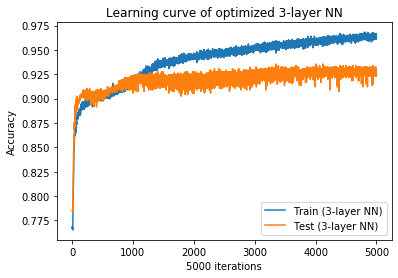

Final training accuracy of 4-layer NN is 0.9394946808510641
Final test accuracy of 4-layer NN is 0.9135220050811768


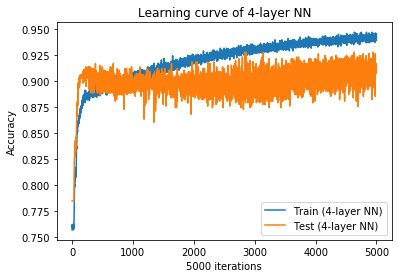

Final loss of 3-layer NN is 0.09186011552810669
Final loss of 4-layer NN is 0.1022304967045784


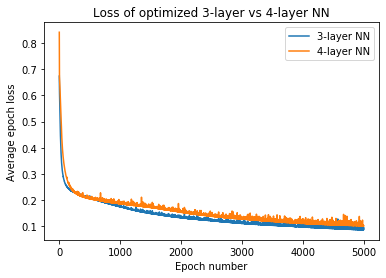

Final test accuracy of optimized 3-layer NN is 0.9245283007621765
Final test accuracy of 4-layer NN is 0.9135220050811768


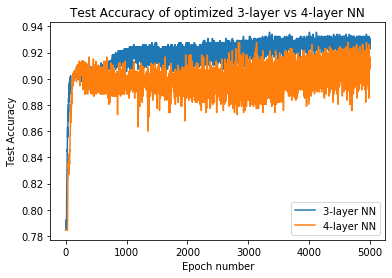

In [29]:
# Plot learning curves
fig, ax = plt.subplots()
print('Final training accuracy of optimized 3-layer NN is {}'.format(train_acc[-1]))
print('Final test accuracy of optimized 3-layer NN is {}'.format(test_acc[-1]))
ax.plot(range(epochs), train_acc, label='Train (3-layer NN)')
ax.plot(range(epochs), test_acc, label='Test (3-layer NN)')
legend = ax.legend(loc='lower right')
plt.xlabel(str(epochs) +' iterations')
plt.ylabel('Accuracy')
plt.title('Learning curve of optimized 3-layer NN')
plt.savefig('figures/project_1a_q5_1.png')
plt.show()

fig2, ax2 = plt.subplots()
print('Final training accuracy of 4-layer NN is {}'.format(train_acc_4[-1]))
print('Final test accuracy of 4-layer NN is {}'.format(test_acc_4[-1]))
ax2.plot(range(epochs), train_acc_4, label='Train (4-layer NN)')
ax2.plot(range(epochs), test_acc_4, label='Test (4-layer NN)')
legend = ax2.legend(loc='lower right')
plt.xlabel(str(epochs) +' iterations')
plt.ylabel('Accuracy')
plt.title('Learning curve of 4-layer NN')
plt.savefig('figures/project_1a_q5_2.png')
plt.show()

fig3, ax3 = plt.subplots()
print('Final loss of 3-layer NN is {}'.format(loss[-1]))
print('Final loss of 4-layer NN is {}'.format(loss_4[-1]))
ax3.plot(range(epochs), loss, label='3-layer NN')
ax3.plot(range(epochs), loss_4, label='4-layer NN')
legend = ax3.legend(loc='upper right')
plt.xlabel('Epoch number')
plt.ylabel('Average epoch loss')
plt.title('Loss of optimized 3-layer vs 4-layer NN')
plt.savefig('figures/project_1a_q5_3.png')
plt.show()

fig4, ax4 = plt.subplots()
print('Final test accuracy of optimized 3-layer NN is {}'.format(test_acc[-1]))
print('Final test accuracy of 4-layer NN is {}'.format(test_acc_4[-1]))
ax4.plot(range(epochs), test_acc, label='3-layer NN')
ax4.plot(range(epochs), test_acc_4, label='4-layer NN')
legend = ax4.legend(loc='lower right')
plt.xlabel('Epoch number')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy of optimized 3-layer vs 4-layer NN')
plt.savefig('figures/project_1a_q5_4.png')
plt.show()

In [30]:
# Train with optimzed hyperparameters
train_acc_4_opt, test_acc_4_opt, loss_4_opt = training(cv_and_trainX, cv_and_trainY, num_classes=OPTIMAL_NEURON_NUM,
                                                       decay_parameter=OPTIMAL_DECAY_PARAMETER,batch_size=OPTIMAL_BATCH_SIZE,
                                                       no_of_layers=4, testX=testX, testY=testY, use_small_dataset=False)

iter 0: accuracy 0.767287, test accuracy 0.784591, loss 0.684044
iter 100: accuracy 0.894947, test accuracy 0.894654, loss 0.241081
iter 200: accuracy 0.90758, test accuracy 0.902516, loss 0.207592
iter 300: accuracy 0.914229, test accuracy 0.902516, loss 0.190198
iter 400: accuracy 0.919548, test accuracy 0.910377, loss 0.176961
iter 500: accuracy 0.932846, test accuracy 0.922956, loss 0.179228
iter 600: accuracy 0.935505, test accuracy 0.915094, loss 0.150873
iter 700: accuracy 0.942819, test accuracy 0.922956, loss 0.140506
iter 800: accuracy 0.940824, test accuracy 0.922956, loss 0.136315
iter 900: accuracy 0.950133, test accuracy 0.910377, loss 0.134682
iter 1000: accuracy 0.948138, test accuracy 0.891509, loss 0.156389
iter 1100: accuracy 0.957447, test accuracy 0.926101, loss 0.130178
iter 1200: accuracy 0.960771, test accuracy 0.929245, loss 0.108325
iter 1300: accuracy 0.964096, test accuracy 0.915094, loss 0.100292
iter 1400: accuracy 0.972074, test accuracy 0.930818, loss 0.

Final training accuracy of 4-layer NN is 0.989361702127658
Final test accuracy of 4-layer NN is 0.9323899149894714


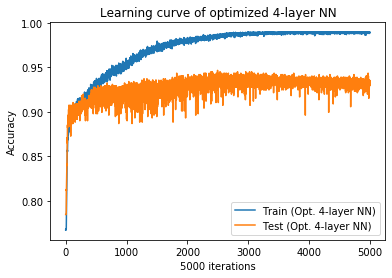

Final loss of optimized 3-layer NN is 0.09186011552810669
Final loss of optimized 4-layer NN is 0.017194228246808052


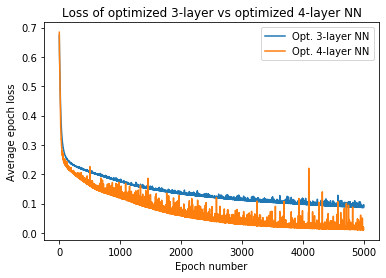

Final test accuracy of optimized 3-layer NN is 0.9245283007621765
Final test accuracy of optimized 4-layer NN is 0.9323899149894714


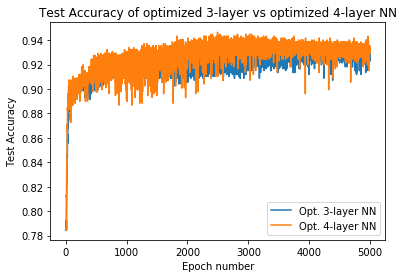

In [31]:
fig, ax = plt.subplots()
print('Final training accuracy of 4-layer NN is {}'.format(train_acc_4_opt[-1]))
print('Final test accuracy of 4-layer NN is {}'.format(test_acc_4_opt[-1]))
ax.plot(range(epochs), train_acc_4_opt, label='Train (Opt. 4-layer NN)')
ax.plot(range(epochs), test_acc_4_opt, label='Test (Opt. 4-layer NN)')
legend = ax.legend(loc='lower right')
plt.xlabel(str(epochs) +' iterations')
plt.ylabel('Accuracy')
plt.title('Learning curve of optimized 4-layer NN')
plt.savefig('figures/project_1a_q5_5.png')
plt.show()

fig2, ax2 = plt.subplots()
print('Final loss of optimized 3-layer NN is {}'.format(loss[-1]))
print('Final loss of optimized 4-layer NN is {}'.format(loss_4_opt[-1]))
ax2.plot(range(epochs), loss, label='Opt. 3-layer NN')
ax2.plot(range(epochs), loss_4_opt, label='Opt. 4-layer NN')
legend = ax2.legend(loc='upper right')
plt.xlabel('Epoch number')
plt.ylabel('Average epoch loss')
plt.title('Loss of optimized 3-layer vs optimized 4-layer NN')
plt.savefig('figures/project_1a_q5_6.png')
plt.show()

fig3, ax3 = plt.subplots()
print('Final test accuracy of optimized 3-layer NN is {}'.format(test_acc[-1]))
print('Final test accuracy of optimized 4-layer NN is {}'.format(test_acc_4_opt[-1]))
ax3.plot(range(epochs), test_acc, label='Opt. 3-layer NN')
ax3.plot(range(epochs), test_acc_4_opt, label='Opt. 4-layer NN')
legend = ax3.legend(loc='lower right')
plt.xlabel('Epoch number')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy of optimized 3-layer vs optimized 4-layer NN')
plt.savefig('figures/project_1a_q5_7.png')
plt.show()